# Import all the libraries needed

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import json
import time
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the models (MLP, CNN)

In [14]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        # Create a list to hold the layers of the network
        layers = []
        prev_size = input_size
        # Dynamically add hidden layers based on provided hidden_sizes list
        for hidden_size in hidden_sizes:
            # Add a fully connected (Linear) layer
            layers.append(nn.Linear(prev_size, hidden_size))
            # Add a ReLU activation function for non-linearity
            layers.append(nn.ReLU())
            # Update the size for the next layer's input
            prev_size = hidden_size
        # Add the final output layer
        layers.append(nn.Linear(prev_size, output_size))
        # Use nn.Sequential to stack all layers into a single model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # Define the forward pass using the sequential model
        return self.model(x)

In [15]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self, num_filters, kernel_size, output_size):
        super(CNN, self).__init__()

        # First convolutional layer:
        # - 1 input channel (grayscale image)
        # - num_filters output channels
        # - kernel_size is the size of the filter
        # - padding=1 keeps spatial dimensions nearly the same after convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=1)

        # Max pooling layer with 2x2 window and stride of 2 (downsamples by a factor of 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer:
        # - input channels = num_filters from previous layer
        # - output channels = num_filters * 2 (doubling for more feature complexity)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, padding=1)

        # Calculate the flattened output size after conv and pooling layers to define the first fully connected layer
        conv_output_size = self._get_conv_output((1, 28, 28), num_filters, kernel_size)

        # First fully connected layer after flattening convolution output
        self.fc1 = nn.Linear(conv_output_size, 128)

        # Final fully connected layer producing the output classes
        self.fc2 = nn.Linear(128, output_size)

        # ReLU activation function used after each layer
        self.relu = nn.ReLU()

    def _get_conv_output(self, shape, num_filters, kernel_size):
        # Utility function to dynamically compute the flattened output size
        # from the conv and pooling layers given the input shape
        x = torch.zeros(1, *shape)  # Create a dummy input tensor
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return int(np.prod(x.shape[1:]))  # Flatten the output and compute total features

    def forward(self, x):
        # Forward pass logic:
        # - Reshape flat input into 2D image format with single channel
        x = x.view(-1, 1, 28, 28)

        # Apply first convolution + ReLU activation + pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Apply second convolution + ReLU activation + pooling
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the 2D feature maps into a 1D vector
        x = x.view(x.size(0), -1)

        # Apply first fully connected layer + ReLU
        x = self.relu(self.fc1(x))

        # Output layer 
        x = self.fc2(x)

        return x

# Load the best models

In [16]:
# Load best parameters
with open("mlp_best_params.json") as f:
    mlp_best_params = json.load(f)
    
with open("cnn_best_params.json") as f:
    cnn_best_params = json.load(f)

# Use gpu for better performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train, evaluation and storing the results

## MLP Model

In [35]:
# Load flattened MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [42]:
# Initialize the best MLP model with optimal hyperparameters found during tuning
mlp_model = MLP(28*28, mlp_best_params['hidden_sizes'], 10).to(device)

# Define the loss function for multi-class classification
mlp_criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with the best learning rate
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=mlp_best_params['learning_rate'])

# Prepare the training DataLoader with the best batch size
mlp_train_loader = DataLoader(train_dataset, batch_size=mlp_best_params['batch_size'], shuffle=True)

# Start the timer to record training duration
mlp_start_time = time.time()

# Train the model for 50 epochs
for epoch in range(50):
    mlp_model.train()  # Set model to training mode
    for images, labels in mlp_train_loader:
        # Move inputs and targets to the selected device 
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        mlp_optimizer.zero_grad()

        # Forward pass
        outputs = mlp_model(images)

        # Compute loss
        mlp_loss = mlp_criterion(outputs, labels)

        # Backward pass (compute gradients)
        mlp_loss.backward()

        # Update weights
        mlp_optimizer.step()

# Record total training time
mlp_training_time = time.time() - mlp_start_time

In [43]:
# Set the model to evaluation mode to disable dropout and batch norm behaviors
mlp_model.eval()

# Prepare test DataLoader (no shuffling for reproducibility)
mlp_test_loader = DataLoader(test_dataset, batch_size=mlp_best_params['batch_size'], shuffle=False)

# Lists to store true labels, predicted labels, and class probabilities
mlp_y_true, mlp_y_pred, mlp_y_scores = [], [], []

# Disable gradient tracking for evaluation/inference
with torch.no_grad():
    for images, labels in mlp_test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the trained model
        outputs = mlp_model(images)

        # Compute softmax probabilities for each class
        probs = torch.softmax(outputs, dim=1)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Store results on CPU for metrics computation
        mlp_y_true.extend(labels.cpu().numpy())
        mlp_y_pred.extend(predicted.cpu().numpy())
        mlp_y_scores.extend(probs.cpu().numpy())

# ----- Compute Evaluation Metrics -----
mlp_accuracy = accuracy_score(mlp_y_true, mlp_y_pred)
mlp_precision = precision_score(mlp_y_true, mlp_y_pred, average='macro')
mlp_recall = recall_score(mlp_y_true, mlp_y_pred, average='macro')
mlp_f1 = f1_score(mlp_y_true, mlp_y_pred, average='macro')

# ----- Store Predictions and Probabilities -----

# Create a DataFrame with true and predicted labels
mlp_results_df = pd.DataFrame({
    'true_label': mlp_y_true,
    'predicted_label': mlp_y_pred
})

# Create a DataFrame for softmax probabilities per class (0–9)
mlp_probs_df = pd.DataFrame(mlp_y_scores, columns=[f'prob_{i}' for i in range(10)])

# Concatenate predictions and probabilities into a single DataFrame
mlp_results_df = pd.concat([mlp_results_df, mlp_probs_df], axis=1)

# ----- Store Final Evaluation Metrics and Training Time -----
mlp_metrics = {
    "accuracy": mlp_accuracy,
    "precision": mlp_precision,
    "recall": mlp_recall,
    "f1_score": mlp_f1,
    "training_time": mlp_training_time
}

# Wrap metrics in a DataFrame for easy export or comparison
mlp_metrics_df = pd.DataFrame([mlp_metrics])

## CNN Model

In [20]:
# Load MNIST dataset for CNN (Not flattened like MLP)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [21]:
# Initialize the CNN model with the best parameters (number of filters, kernel size, and number of classes)
cnn_model = CNN(cnn_best_params['num_filters'], cnn_best_params['kernel_size'], 10).to(device)

# Define the loss function for classification: CrossEntropyLoss for multi-class classification
cnn_criterion = nn.CrossEntropyLoss()

# Set up the optimizer using Adam, which is adaptive and popular for training CNNs, with learning rate from best parameters
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=cnn_best_params['learning_rate'])

# Set up the data loader for the training dataset. It loads data in batches, shuffles the dataset for each epoch
cnn_train_loader = DataLoader(train_dataset, batch_size=cnn_best_params['batch_size'], shuffle=True)

# Record the start time of training to measure training duration
cnn_start_time = time.time()

# Training loop over 60 epochs
for epoch in range(60):
    cnn_model.train()  # Set the model to training mode
    
    # Iterate over the training data in batches
    for images, labels in cnn_train_loader:
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)
        
        # Zero out gradients from the previous iteration
        cnn_optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing images through the CNN model
        outputs = cnn_model(images)
        
        # Compute the loss between predicted outputs and actual labels
        cnn_loss = cnn_criterion(outputs, labels)
        
        # Backpropagate the loss to compute gradients for model parameters
        cnn_loss.backward()
        
        # Update model parameters using the optimizer (based on computed gradients)
        cnn_optimizer.step()

# Calculate the total training time taken for the CNN model
cnn_training_time = time.time() - cnn_start_time

In [22]:
# Set the model to evaluation mode (important to disable dropout and batch normalization layers during inference)
cnn_model.eval()

# Set up the data loader for the test dataset. No shuffling needed for evaluation
cnn_test_loader = DataLoader(test_dataset, batch_size=cnn_best_params['batch_size'], shuffle=False)

# Initialize lists to store true labels, predicted labels, and prediction probabilities
cnn_y_true, cnn_y_pred, cnn_y_scores = [], [], []

# Disable gradient computation to save memory and computation during inference
with torch.no_grad():
    # Iterate over the test data in batches
    for images, labels in cnn_test_loader:
        # Move images and labels to the specified device 
        images, labels = images.to(device), labels.to(device)
        
        # Perform forward pass: compute predicted outputs by passing images through the CNN model
        outputs = cnn_model(images)
        
        # Apply softmax to get probabilities for each class
        probs = torch.softmax(outputs, dim=1)
        
        # Get the class with the highest probability (the predicted class)
        _, predicted = torch.max(outputs, 1)

        # Store the true labels, predicted labels, and the class probabilities
        cnn_y_true.extend(labels.cpu().numpy())
        cnn_y_pred.extend(predicted.cpu().numpy())
        cnn_y_scores.extend(probs.cpu().numpy())

# Compute evaluation metrics
cnn_accuracy = accuracy_score(cnn_y_true, cnn_y_pred)
cnn_precision = precision_score(cnn_y_true, cnn_y_pred, average='macro')
cnn_recall = recall_score(cnn_y_true, cnn_y_pred, average='macro')
cnn_f1 = f1_score(cnn_y_true, cnn_y_pred, average='macro')

# Store predictions and probabilities in a DataFrame for further analysis
cnn_results_df = pd.DataFrame({
    'true_label': cnn_y_true,
    'predicted_label': cnn_y_pred
})

# Create a DataFrame for the predicted probabilities for each class (10 classes)
cnn_probs_df = pd.DataFrame(cnn_y_scores, columns=[f'prob_{i}' for i in range(10)])

# Concatenate the results (true labels, predicted labels, and probabilities) into one DataFrame
cnn_results_df = pd.concat([cnn_results_df, cnn_probs_df], axis=1)

# Store the evaluation metrics (accuracy, precision, recall, F1 score, and training time) in a dictionary
cnn_metrics = {
    "accuracy": cnn_accuracy,
    "precision": cnn_precision,
    "recall": cnn_recall,
    "f1_score": cnn_f1,
    "training_time": cnn_training_time
}

# Convert the metrics dictionary to a DataFrame for easier presentation or saving
cnn_metrics_df = pd.DataFrame([cnn_metrics])

# Graphs

## Confusion Matrices

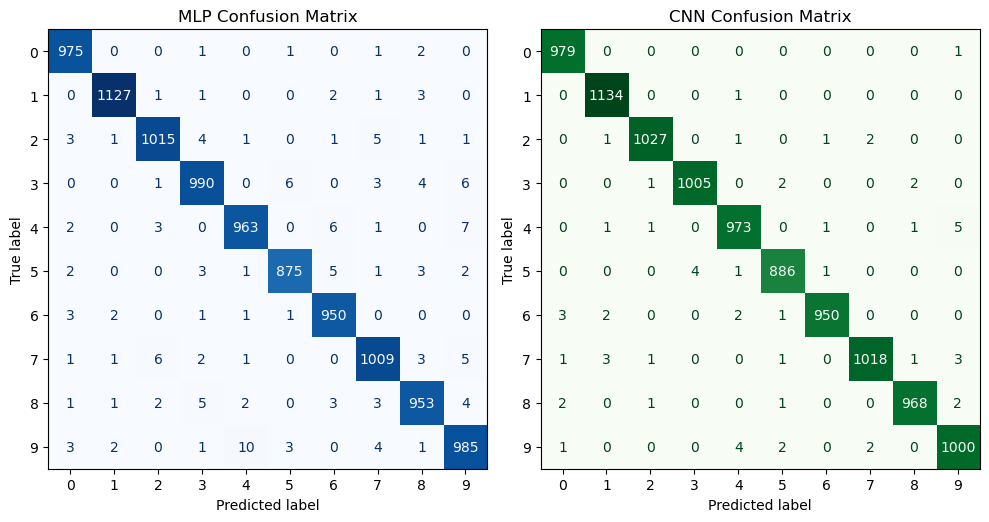

In [23]:
# Create confusion matrices
mlp_cm = confusion_matrix(mlp_y_true, mlp_y_pred)
cnn_cm = confusion_matrix(cnn_y_true, cnn_y_pred)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot MLP confusion matrix
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=range(10))
disp_mlp.plot(ax=axs[0], cmap='Blues', colorbar=False)
axs[0].set_title("MLP Confusion Matrix")

# Plot CNN confusion matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=range(10))
disp_cnn.plot(ax=axs[1], cmap='Greens', colorbar=False)
axs[1].set_title("CNN Confusion Matrix")

# Adjust layout
plt.tight_layout()
plt.show()

## ROC Curves

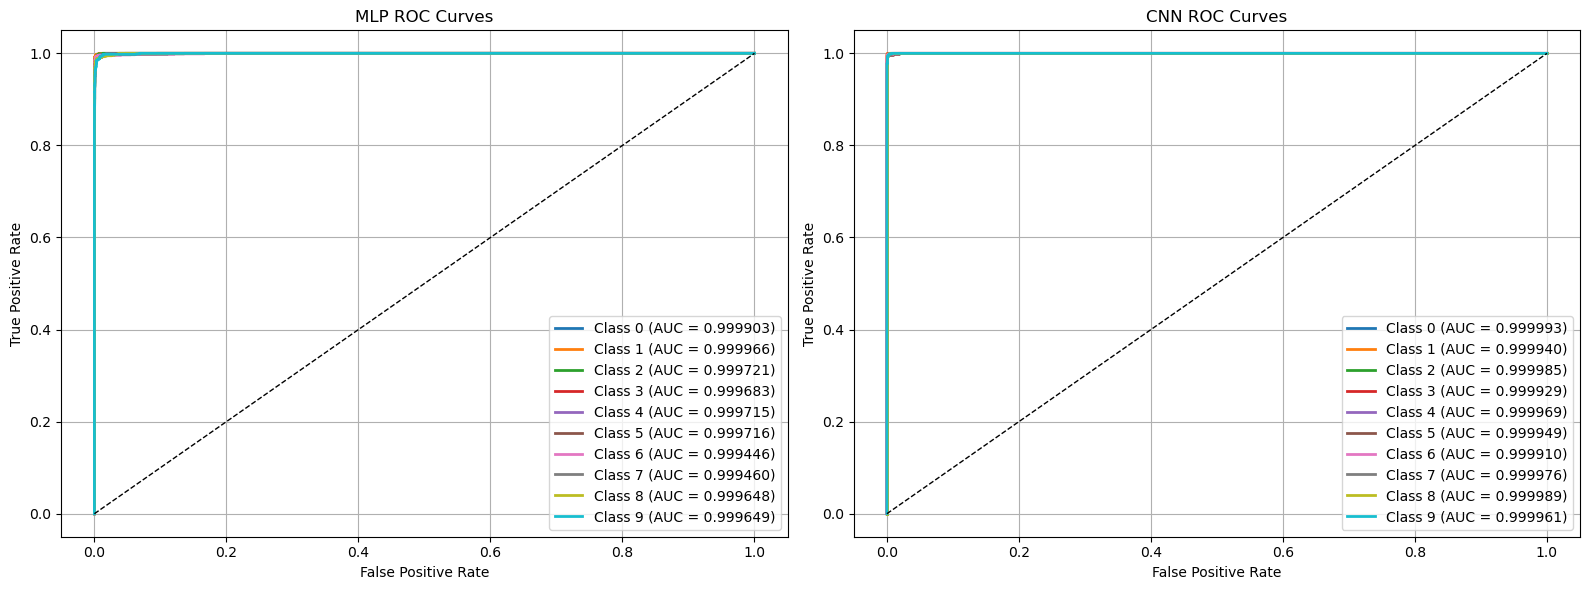

In [24]:
# Binarize the true labels (needed for multi-class ROC)
mlp_y_true_bin = label_binarize(mlp_y_true, classes=range(10))
cnn_y_true_bin = label_binarize(cnn_y_true, classes=range(10))

# Ensure NumPy arrays for slicing
mlp_y_true_bin = np.array(mlp_y_true_bin)
mlp_y_scores = np.array(mlp_y_scores)
cnn_y_true_bin = np.array(cnn_y_true_bin)
cnn_y_scores = np.array(cnn_y_scores)

# Prepare class colors
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curves side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- MLP ROC ---
for i, color in zip(range(10), colors):
    fpr, tpr, _ = roc_curve(mlp_y_true_bin[:, i], mlp_y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.6f})")

axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set_title("MLP ROC Curves")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")
axs[0].grid(True)

# Reset color cycle
colors = cycle(plt.cm.tab10.colors)

# --- CNN ROC ---
for i, color in zip(range(10), colors):
    fpr, tpr, _ = roc_curve(cnn_y_true_bin[:, i], cnn_y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.6f})")

axs[1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[1].set_title("CNN ROC Curves")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="lower right")
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Overfitting Line Plot

In [25]:
# Load results CSVs
mlp_df = pd.read_csv("mlp_results.csv")
cnn_df = pd.read_csv("cnn_results.csv")

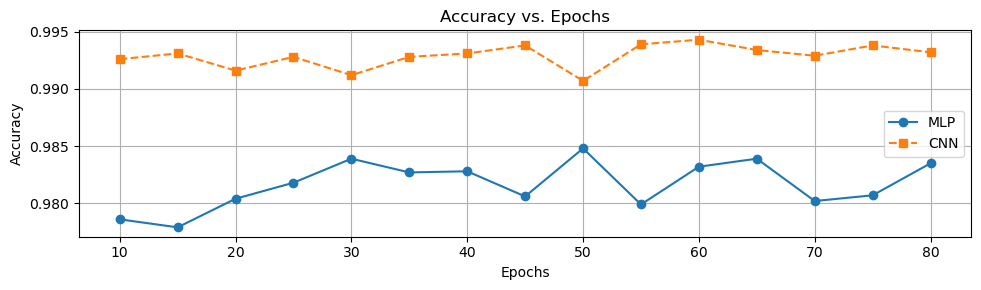

In [26]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(10, 3))
plt.plot(mlp_df['epochs'], mlp_df['accuracy'], label='MLP', marker='o', linestyle='-')
plt.plot(cnn_df['epochs'], cnn_df['accuracy'], label='CNN', marker='s', linestyle='--')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Efficiency Plot

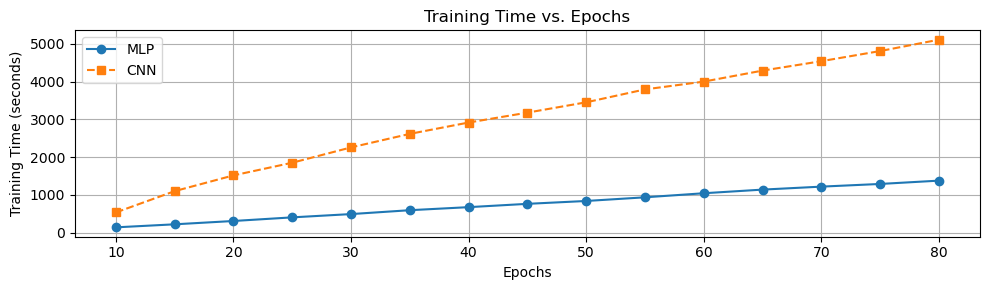

In [29]:
# Plot Training Time vs. Epochs
plt.figure(figsize=(10, 3))
plt.plot(mlp_df['epochs'], mlp_df['training_time'], label='MLP', marker='o', linestyle='-')
plt.plot(cnn_df['epochs'], cnn_df['training_time'], label='CNN', marker='s', linestyle='--')
plt.title('Training Time vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Accuracy vs Training time

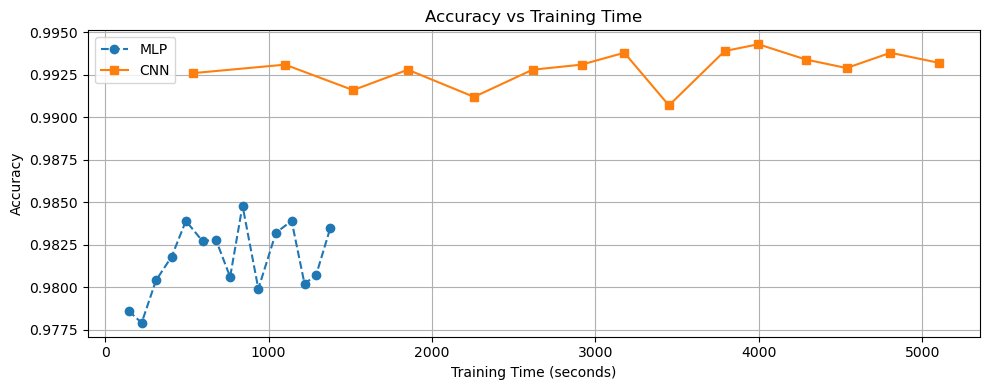

In [33]:
# Plot Training Time vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(mlp_df["training_time"], mlp_df["accuracy"], marker='o', label='MLP', linestyle='--')
plt.plot(cnn_df["training_time"], cnn_df["accuracy"], marker='s', label='CNN', linestyle='-')

# Styling
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Training Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Radar Plot of Final Metrics

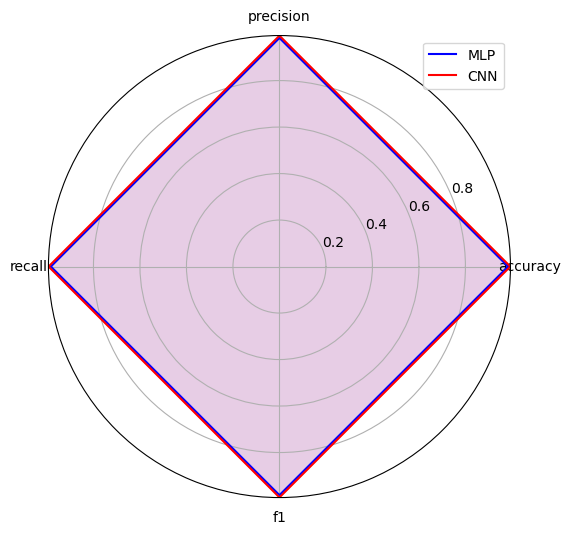

In [28]:
def plot_radar(df_mlp, df_cnn):
    categories = ['accuracy', 'precision', 'recall', 'f1']
    mlp_vals = df_mlp[categories].iloc[-1].values
    cnn_vals = df_cnn[categories].iloc[-1].values

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]  # Complete the loop

    mlp_vals = np.append(mlp_vals, mlp_vals[0])
    cnn_vals = np.append(cnn_vals, cnn_vals[0])

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)

    ax.plot(angles, mlp_vals, label='MLP', color='blue')
    ax.fill(angles, mlp_vals, color='blue', alpha=0.1)

    ax.plot(angles, cnn_vals, label='CNN', color='red')
    ax.fill(angles, cnn_vals, color='red', alpha=0.1)

    plt.legend(loc='upper right')
    plt.show()

plot_radar(mlp_df, cnn_df)